In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pyts
from pyts import classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
#from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize



In [5]:
def load_npy(filename):
    return np.load(filename)

In [6]:
path = "Output_Saved/X_y_ids.npz"

X_y_ids = load_npy(path) 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']


In [7]:
X = X.squeeze()
X.shape

(10000, 1280)

In [8]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series

#tss_scal_smot = tss_scal.copy()

w = 10 #che valore di w usare?

for i,time_series in enumerate(X):
    X[i]= moving_average_smoothing(X[i], w)


In [9]:
X_train_scaled

NameError: name 'X_train_scaled' is not defined

In [10]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

print(X.shape)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
X = X.squeeze()
print(X.shape)


ModuleNotFoundError: No module named 'tslearn'

In [12]:
from pyts.approximation import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

print(X.shape)
#-------------------------#-------------------------
window_size = 4
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)
print(X_paa.shape)

#-------------------------#-------------------------
## SAX with 50 symbols and 500 segments - erano quelli che plottando la TS davano risultato migliore
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=500, alphabet_size_avg=n_sax_symbols) #, scale=True
X_sax = sax.fit_transform(X)
X_sax = X_sax.squeeze()
print(X_sax.shape)

#-------------------------#-------------------------
n_coefs = 64
dft = DiscreteFourierTransform(n_coefs=n_coefs)
X_dft = dft.fit_transform(X)
print(X_dft.shape)


ModuleNotFoundError: No module named 'tslearn'

# RAW KNN

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8000, 1280), (2000, 1280), (8000,), (2000,))

In [14]:
from sklearn.preprocessing import LabelEncoder
# Encode the string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50, 75, 100],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)
grid_search.best_params_


KeyboardInterrupt: 

In [13]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 2, n_neighbors= 5, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train_encoded)

y_pred = knn.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)


In [14]:
y_test

array(['heavy-metal', 'emo', 'happy', ..., 'progressive-house', 'emo',
       'salsa'], dtype='<U17')

In [15]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_decoded))
print('F1-score %s' % f1_score(y_test, y_pred_decoded, average='weighted'))
print(classification_report(y_test, y_pred_decoded, digits=3))


Accuracy 0.1505
F1-score 0.12598369309720187
                   precision    recall  f1-score   support

              emo      0.185     0.050     0.079       100
             folk      0.203     0.120     0.151       100
             goth      0.047     0.020     0.028       100
            happy      0.149     0.330     0.205       100
      heavy-metal      0.059     0.030     0.040       100
       honky-tonk      0.293     0.120     0.170       100
           j-idol      0.140     0.080     0.102       100
             kids      0.069     0.020     0.031       100
   minimal-techno      0.329     0.540     0.409       100
              mpb      0.143     0.040     0.062       100
          new-age      0.087     0.220     0.124       100
            opera      0.070     0.090     0.079       100
            piano      0.060     0.070     0.065       100
progressive-house      0.167     0.350     0.227       100
            salsa      0.241     0.070     0.109       100
        se

In [19]:
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier(random_state=42) 
#establishing random_state for reproducibility
clf_dummy.fit(X_train, y_train_encoded)
y_pred = clf_dummy.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(classification_report(y_test, y_pred_decoded, digits=3))


                   precision    recall  f1-score   support

              emo      0.050     1.000     0.095       100
             folk      0.000     0.000     0.000       100
             goth      0.000     0.000     0.000       100
            happy      0.000     0.000     0.000       100
      heavy-metal      0.000     0.000     0.000       100
       honky-tonk      0.000     0.000     0.000       100
           j-idol      0.000     0.000     0.000       100
             kids      0.000     0.000     0.000       100
   minimal-techno      0.000     0.000     0.000       100
              mpb      0.000     0.000     0.000       100
          new-age      0.000     0.000     0.000       100
            opera      0.000     0.000     0.000       100
            piano      0.000     0.000     0.000       100
progressive-house      0.000     0.000     0.000       100
            salsa      0.000     0.000     0.000       100
        sertanejo      0.000     0.000     0.000       

/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

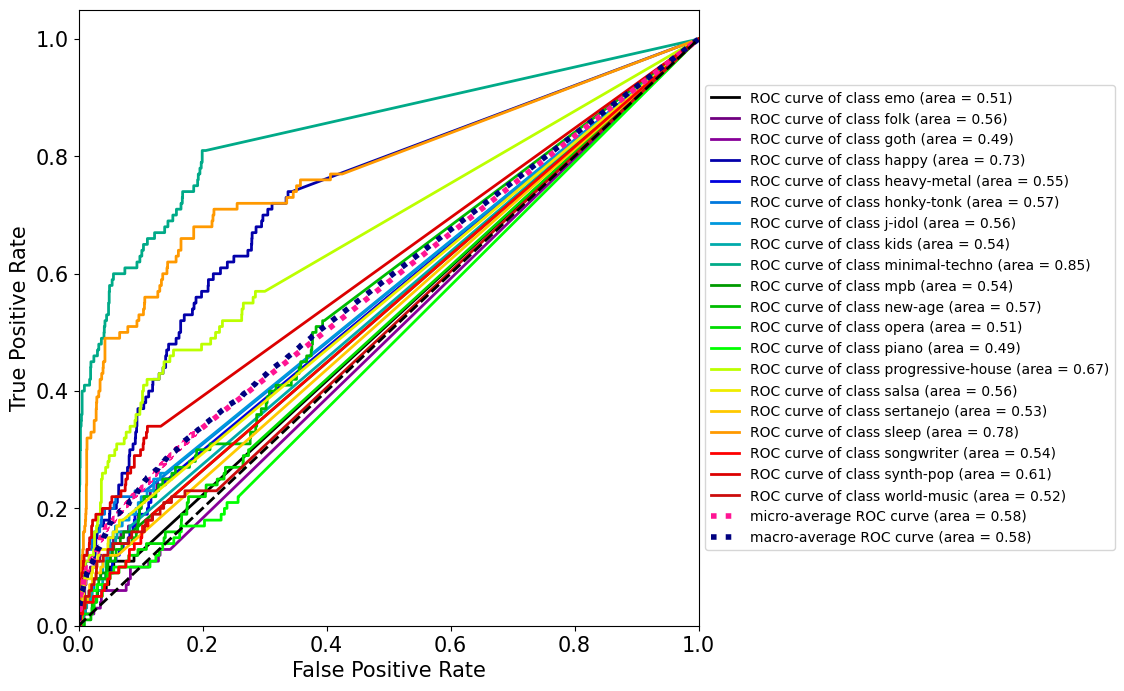

In [16]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# DFT KNN

In [17]:
X = X_dft.copy()
X


array([[ 7.86037901e-14, -1.49022638e+02, -6.38604540e+02, ...,
        -1.13288777e+01,  2.15736189e+01, -5.07357688e+01],
       [-4.47419879e-13,  7.87986057e+01,  4.97785038e+00, ...,
        -1.51012109e+00,  3.93684735e+01,  2.74540503e+01],
       [-6.33493258e-13, -2.75116871e+02, -2.42668573e+02, ...,
        -1.74102736e+02, -4.68913927e-01,  4.63488470e+01],
       ...,
       [ 7.05657754e-13,  3.87714936e+02, -2.45228341e+02, ...,
         8.19612742e+00, -4.29421093e-01,  1.33726900e+01],
       [-9.76996262e-14,  1.88317433e+02,  5.97238531e+02, ...,
        -3.16431005e+01,  8.58178224e+01,  1.59035627e+01],
       [-3.37507799e-14,  2.08350516e+02, -7.87678090e+01, ...,
         3.31426832e+01, -4.42499857e+01, -1.67375823e+01]])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 64), (2000, 64), (8000,), (2000,))

In [19]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)
grid_search.best_params_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [22]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p=2, n_neighbors=1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.109
F1-score 0.08981626659919263
                   precision    recall  f1-score   support

              emo      0.077     0.020     0.032       100
             folk      0.154     0.060     0.086       100
             goth      0.077     0.030     0.043       100
            happy      0.119     0.240     0.159       100
      heavy-metal      0.086     0.030     0.044       100
       honky-tonk      0.203     0.120     0.151       100
           j-idol      0.263     0.100     0.145       100
             kids      0.016     0.010     0.012       100
   minimal-techno      0.073     0.760     0.133       100
              mpb      0.118     0.020     0.034       100
          new-age      0.125     0.030     0.048       100
            opera      0.095     0.020     0.033       100
            piano      0.077     0.020     0.032       100
progressive-house      0.081     0.120     0.097       100
            salsa      0.192     0.050     0.079       100
        ser

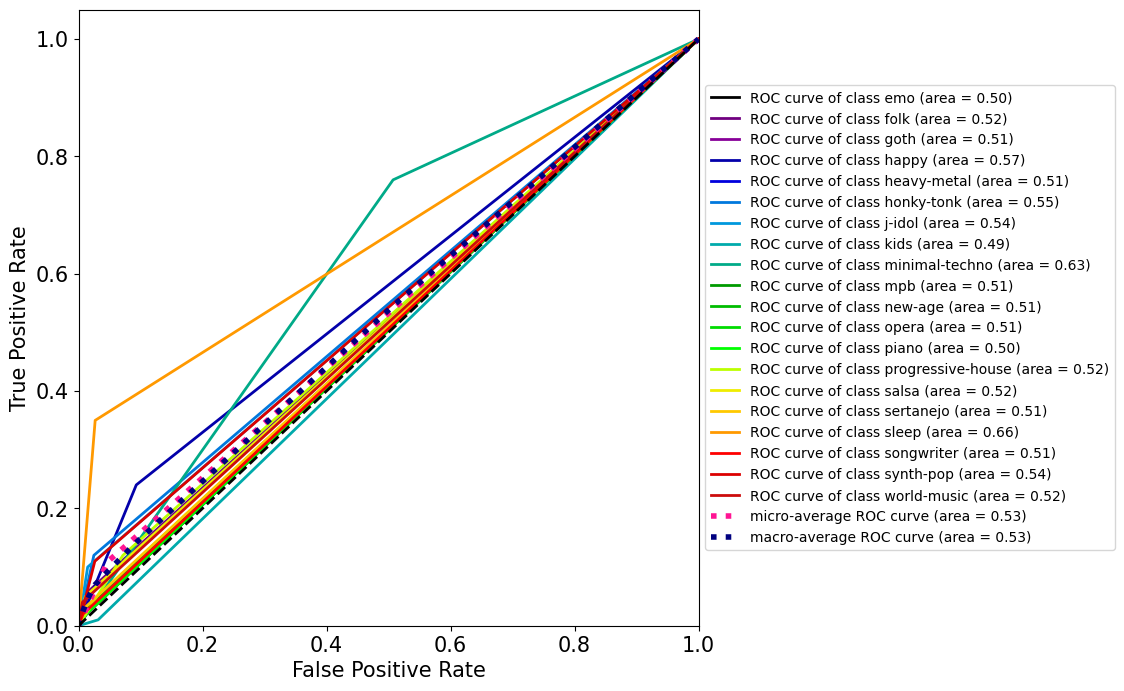

In [23]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# PAA KNN

In [24]:
X = X_paa.copy()
X

array([[-1.94012996, -0.72566842,  0.05443121, ..., -0.62347671,
        -0.50806192, -1.17783537],
       [ 0.58717584,  2.43508472,  2.10611483, ...,  0.17699306,
         0.70429315, -0.88519399],
       [-1.93265466, -0.41395938, -0.37029556, ...,  0.46122616,
         1.8909798 ,  0.61588532],
       ...,
       [-0.91904599,  0.24543145,  0.85457686, ...,  2.25395302,
         2.01051417,  0.19843889],
       [-1.80059939, -1.21339975, -0.64195379, ...,  0.30913194,
        -0.37682751, -1.60549484],
       [-2.59051733, -0.27409553, -0.15876665, ...,  0.08028536,
         0.24737576, -1.09409476]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 320), (2000, 320), (8000,), (2000,))

In [26]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test


In [27]:
param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)
grid_search.best_params_

{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

In [28]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p=2, n_neighbors=1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.146
F1-score 0.12779066168930261
                   precision    recall  f1-score   support

              emo      0.129     0.040     0.061       100
             folk      0.152     0.120     0.134       100
             goth      0.038     0.020     0.026       100
            happy      0.126     0.290     0.175       100
      heavy-metal      0.123     0.090     0.104       100
       honky-tonk      0.250     0.140     0.179       100
           j-idol      0.176     0.120     0.143       100
             kids      0.114     0.040     0.059       100
   minimal-techno      0.317     0.520     0.394       100
              mpb      0.167     0.070     0.099       100
          new-age      0.071     0.130     0.092       100
            opera      0.056     0.060     0.058       100
            piano      0.071     0.080     0.075       100
progressive-house      0.161     0.270     0.201       100
            salsa      0.140     0.060     0.084       100
        ser

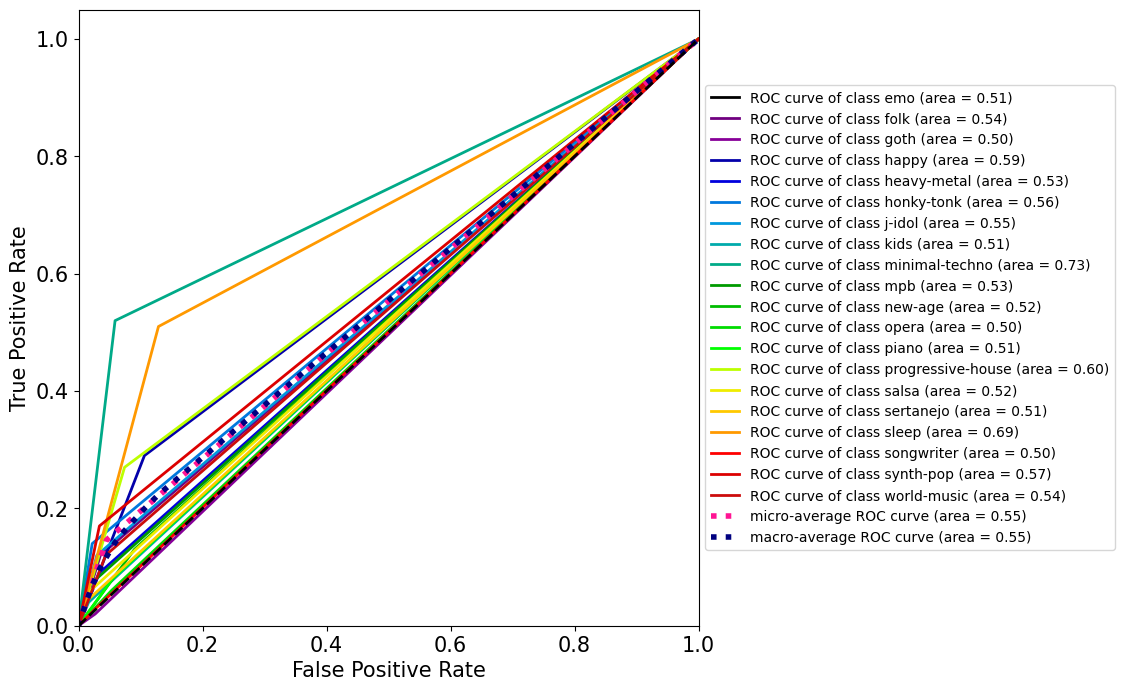

In [29]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# SAX KNN

In [33]:
X = X_sax.copy()
X


array([[0, 0, 1, ..., 0, 0, 0],
       [5, 8, 9, ..., 4, 3, 2],
       [0, 0, 3, ..., 6, 5, 3],
       ...,
       [1, 2, 5, ..., 4, 6, 7],
       [0, 0, 0, ..., 9, 9, 9],
       [0, 0, 3, ..., 4, 3, 4]])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 500), (2000, 500), (8000,), (2000,))

In [35]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test


In [36]:
param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train_encoded)
grid_search.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

In [39]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p=1, n_neighbors=3, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))


Accuracy 0.1155
F1-score 0.09320207359116098
                   precision    recall  f1-score   support

              emo      0.124     0.140     0.131       100
             folk      0.076     0.130     0.096       100
             goth      0.033     0.060     0.042       100
            happy      0.096     0.460     0.159       100
      heavy-metal      0.113     0.080     0.094       100
       honky-tonk      0.139     0.110     0.123       100
           j-idol      0.089     0.040     0.055       100
             kids      0.000     0.000     0.000       100
   minimal-techno      0.263     0.520     0.349       100
              mpb      0.070     0.030     0.042       100
          new-age      0.096     0.130     0.111       100
            opera      0.058     0.060     0.059       100
            piano      0.054     0.030     0.038       100
progressive-house      0.307     0.270     0.287       100
            salsa      0.000     0.000     0.000       100
        se

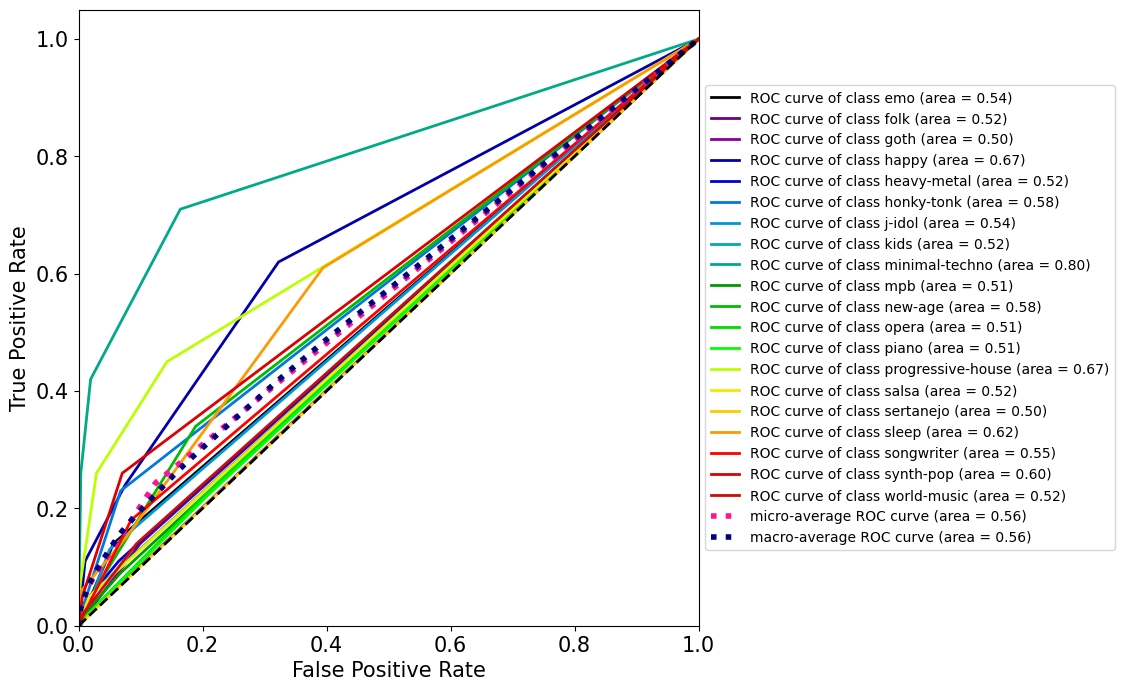

In [40]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# NEURAL NETWORKS

In [41]:
from sklearn.linear_model import RidgeClassifierCV


In [1]:
from sktime.transformations.panel.rocket import Rocket
X_paa.shape
X = X_paa.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


NameError: name 'X_paa' is not defined

In [12]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  # Apply the same transformation to y_test


NameError: name 'LabelEncoder' is not defined

In [44]:
#Rocket univariate -> ci deve essere una sola colonna
x_train_dftEmb = X_train.reshape(8000,1,320)
x_test_dftEmb = X_test.reshape(2000,1,320)


In [45]:

rocket = Rocket()
rocket.fit(x_train_dftEmb)
x_train_transform_rocket = rocket.transform(x_train_dftEmb)
x_test_transform_rocket = rocket.transform(x_test_dftEmb)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [47]:
clf_R = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)) 
clf_R.fit(x_train_transform_rocket, y_train_encoded)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [48]:
y_pred = clf_R.predict(x_test_transform_rocket)
y_pred_decoded = label_encoder.inverse_transform(y_pred)


In [49]:
print('F1-score %s' % f1_score(y_test, y_pred_decoded, average='weighted'))
print()
print(classification_report(y_test, y_pred_decoded,digits=3))


F1-score 0.2489733342820091

                   precision    recall  f1-score   support

              emo      0.149     0.140     0.144       100
             folk      0.106     0.100     0.103       100
             goth      0.046     0.040     0.043       100
            happy      0.624     0.530     0.573       100
      heavy-metal      0.247     0.240     0.244       100
       honky-tonk      0.236     0.250     0.243       100
           j-idol      0.265     0.270     0.267       100
             kids      0.212     0.180     0.195       100
   minimal-techno      0.585     0.690     0.633       100
              mpb      0.045     0.040     0.042       100
          new-age      0.235     0.310     0.267       100
            opera      0.174     0.160     0.167       100
            piano      0.147     0.160     0.153       100
progressive-house      0.239     0.260     0.249       100
            salsa      0.333     0.330     0.332       100
        sertanejo      0.1

# CNN

In [13]:
from sklearn.preprocessing import LabelEncoder
# Encode the string labels into integers
label_encoder = LabelEncoder()


In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
X = X_paa.copy()
y_labenc = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_labenc, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8000, 320), (2000, 320), (8000,), (2000,))

In [16]:
from sktime.classification.deep_learning import CNNClassifier

import tensorflow as tf
from tensorflow import keras


In [17]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [18]:
from sktime.classification.deep_learning import CNNClassifier
import tensorflow as tf

# Print TensorFlow and sktime versions
print("TensorFlow version:", tf.__version__)
print("sktime version:", CNNClassifier.__module__.split('.')[0])

# Initialize CNNClassifier
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

print("CNNClassifier initialized successfully!")


TensorFlow version: 2.18.0
sktime version: sktime
CNNClassifier initialized successfully!


In [19]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)


In [20]:
%%time
cnn.fit(X_train, y_train)
cnn.score(X_test, y_test)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CPU times: user 13.2 s, sys: 2.08 s, total: 15.3 s
Wall time: 13.1 s


0.167

NameError: name 'plt' is not defined

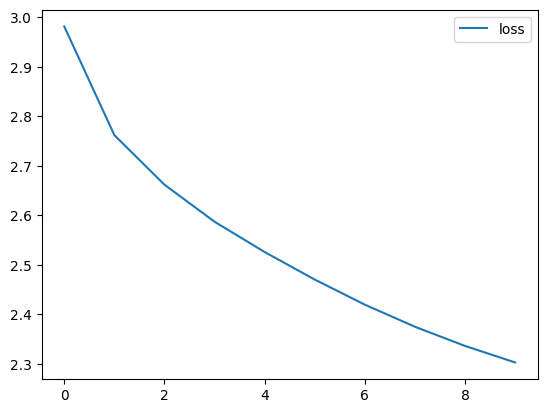

In [23]:
import seaborn as sns
sns.lineplot(cnn.history.history["loss"], label="loss")
plt.show()


### Keras

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LeakyReLU
from keras.layers import Activation, Conv1D, BatchNormalization
from keras.callbacks import EarlyStopping


In [25]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model


In [26]:
n_timesteps = 320
n_outputs = 20

cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 313, 16)        │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 313, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 313, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 313, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 309, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 309, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 309, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 309, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 307, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 307, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 307, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 307, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,692 (41.77 KB)

 Trainable params: 10,468 (40.89 KB)

 Non-trainable params: 224 (896.00 B)

In [27]:
es = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [es]


In [49]:
 #16 min


history = cnn.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)


Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3098 - loss: 2.2329 - val_accuracy: 0.3054 - val_loss: 2.2635
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3071 - loss: 2.2282 - val_accuracy: 0.3029 - val_loss: 2.2620
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.3093 - loss: 2.2218 - val_accuracy: 0.3017 - val_loss: 2.2650
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3131 - loss: 2.2255 - val_accuracy: 0.3033 - val_loss: 2.2600
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3177 - loss: 2.2218 - val_accuracy: 0.3054 - val_loss: 2.2626
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3238 - loss: 2.2235 - val_accuracy: 0.3050 - val_loss: 2.2625
Epoch 7/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.3190 - loss: 2.2164 - val_accuracy: 0.3033 - val_loss: 2.2594
Epoch 8/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.3152 - loss: 2.22

In [53]:
history.history

{'accuracy': [0.30892857909202576,
  0.30517858266830444,
  0.30375000834465027,
  0.3053571283817291,
  0.3092857003211975,
  0.31785714626312256,
  0.31660714745521545,
  0.3125,
  0.3167857229709625,
  0.3130357265472412,
  0.31910714507102966,
  0.3142857253551483,
  0.3119642734527588,
  0.31267857551574707,
  0.3171428442001343,
  0.3157142996788025,
  0.3183928430080414,
  0.3169642984867096,
  0.31410714983940125,
  0.31928572058677673,
  0.3183928430080414,
  0.3155357241630554,
  0.3207142949104309,
  0.3182142972946167,
  0.32875001430511475,
  0.32160714268684387,
  0.31928572058677673,
  0.32249999046325684,
  0.31732141971588135,
  0.3276785612106323,
  0.320892870426178,
  0.3183928430080414,
  0.31803572177886963,
  0.3176785707473755,
  0.3246428668498993,
  0.3246428668498993,
  0.314464271068573,
  0.322857141494751,
  0.3264285624027252,
  0.3201785683631897,
  0.32624998688697815,
  0.31607142090797424,
  0.3283928632736206,
  0.32428571581840515,
  0.3257142901420

In [55]:
summary = pd.DataFrame(history.history) 
summary

,accuracy,loss,val_accuracy,val_loss
0,0.308929,2.251415,0.305417,2.263492
1,0.305179,2.253364,0.302917,2.262008
2,0.303750,2.248191,0.301667,2.264999
3,0.305357,2.250317,0.303333,2.259959
4,0.309286,2.248517,0.305417,2.262552
...,...,...,...,...
95,0.331607,2.145763,0.322083,2.201955
96,0.339286,2.154543,0.322500,2.201946
97,0.344464,2.151568,0.322917,2.194973
98,0.338929,2.143176,0.320833,2.200960


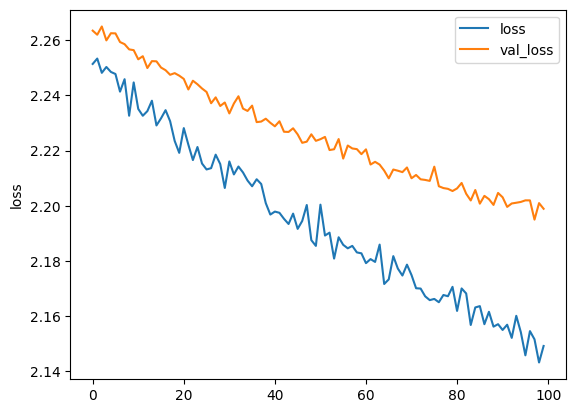

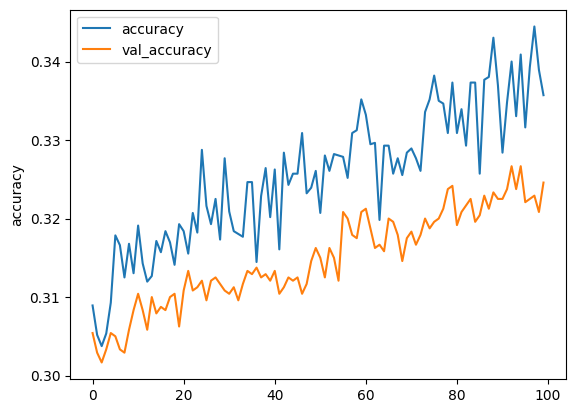

In [56]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()


In [57]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)
print("Accuracy %s" % accuracy_score(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy 0.3325


In [58]:
from sklearn.metrics import classification_report


print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print()
print(classification_report(y_test, y_pred, digits=3))


F1-score 0.3018911297325139

              precision    recall  f1-score   support

           0      0.222     0.160     0.186       100
           1      0.500     0.010     0.020       100
           2      0.000     0.000     0.000       100
           3      0.778     0.700     0.737       100
           4      0.294     0.530     0.379       100
           5      0.184     0.510     0.271       100
           6      0.326     0.150     0.205       100
           7      0.207     0.120     0.152       100
           8      0.556     0.700     0.619       100
           9      0.118     0.040     0.060       100
          10      0.324     0.580     0.416       100
          11      0.389     0.370     0.379       100
          12      0.232     0.190     0.209       100
          13      0.468     0.370     0.413       100
          14      0.518     0.720     0.603       100
          15      0.233     0.470     0.311       100
          16      0.583     0.560     0.571       10